In [1]:
%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from IPython.core.display import SVG

In [2]:
import sys
sys.path.insert(1, './utilities/')

from health_functions import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jerome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jerome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
DUNNHUMBY_PATH = '../data/dunnhumby - The Complete Journey CSV/'

# Import Data

In [4]:
dfList = {}
for r, d, f in os.walk(DUNNHUMBY_PATH):
    for file in f:
        if '.csv' in file:
            print(file)
            dfList[file] = pd.read_csv(os.path.join(r, file))
            
products_df = dfList['product.csv']
transaction_data_df = dfList['transaction_data.csv']
hh_demographic_df = dfList['hh_demographic.csv']

hh_demographic.csv
causal_data.csv
coupon.csv
campaign_table.csv
coupon_redempt.csv
product.csv
campaign_desc.csv
transaction_data.csv


In [5]:
products_df.head(3)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


## Product Data

_We only take the categories which are food related, sorted manually the different departments_

In [6]:
products_sorted = products_df.groupby('DEPARTMENT').count().sort_values(by = 'PRODUCT_ID',ascending = False)
#NB: there are a few food in MISC. TRANS
food_related = np.array(['NUTRITION','GROCERY','PASTRY','MEAT-PCKGD','SEAFOOD-PCKGD','PRODUCE','DELI','MEAT','SALAD BAR','GRO BAKERY','FROZEN GROCERY','SPIRITS','RESTAURANT',''])

products_df = products_df[products_df.DEPARTMENT.isin(food_related)]

#we put all the description in a ingredients column
products_df['ingredients'] = products_df.COMMODITY_DESC + " " + products_df.SUB_COMMODITY_DESC
products_df.drop(["MANUFACTURER","DEPARTMENT","BRAND","COMMODITY_DESC","SUB_COMMODITY_DESC"],axis = 1, inplace = True)

/Users/jerome/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jerome/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
products_df.ingredients = products_df.ingredients.apply(parse_words)

/Users/jerome/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
products_df.ingredients.head()

0           [frozen, ice, crushed, cubed]
2                [bread, italian, french]
3    [fruit, shelf, stable, apple, sauce]
4             [cookies, cones, specialty]
5          [spices, extracts, seasonings]
Name: ingredients, dtype: object

We see that we now have an easily parseable format

## Downloaded food nutrients data

In [9]:
dfList = {}
for r, d, f in os.walk('../data/health'):
    for file in f:
        if '.csv' in file:
            #print(file)
            dfList[file] = pd.read_csv(os.path.join(r, file))
            
branded_food_df = dfList['branded_food.csv']

#link the nutrient id with its name
nutrient_df = dfList['nutrient.csv']

#contains the food articles name and their id test commit
food_df = dfList['food.csv']

#contains the nutrients for each food article
food_nutrients_df = dfList['food_nutrient.csv']

# linke the food articles ids to their potential category
food_category_df = dfList['food_category.csv']

/Users/jerome/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/jerome/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


_We drop useless columns_

In [10]:
#drop unnecessary columns and rename to be more understandable
food_nutrients_df = food_nutrients_df.drop(["data_points","min","max","median","footnote","min_year_acquired","derivation_id"],axis=1)

nutrient_df = nutrient_df.drop(["nutrient_nbr","rank"],axis=1)

food_category_df.drop(["code"],axis=1,inplace=True)
food_category_df.rename(columns={'id':'food_category_id','description':'category'},inplace= True)

food_df.drop(["publication_date"],axis=1,inplace=True)

In [11]:
#filter out only the necessary food nutrients since we have 227, a lot of which aren't necessary to determine if a food is healthy
list_relevant_nutrients = ["Protein", "Total Carbohydrate","Total lipid (fat)","Sucrose",\
                            "Glucose (dextrose)","Sugars, total including NLEA","Fatty acids, total monounsaturated",\
                            "Fatty acids, total polyunsaturated","Fatty acids, total trans","Fatty acids, total saturated","Cholesterol",\
                            "Vitamin E, added","Vitamin K (phylloquinone)","Vitamin B-12","Vitamin B-6",\
                            "Vitamin E (label entry primarily)","Vitamin E (alpha-tocopherol)","Vitamin D","Vitamin A, RAE","Sodium, Na",\
                            "Total fat (NLEA)","Fiber, total dietary","Energy","Carbohydrate, by summation","Fructose"]

nutrient_df = nutrient_df[nutrient_df.name.isin(list_relevant_nutrients)]

In [12]:
nutrient_df.name = nutrient_df.name.apply(trim_nutrient_name)

In [13]:
nutrient_df.head(4)

,id,name,unit_name
1,1003,protein,G
2,1004,total lipid,G
5,1008,energy,KCAL
7,1010,sucrose,G


In [14]:
food_nutrients_df.head()

,id,fdc_id,nutrient_id,amount
0,4178832,346049,1079,0.00
1,4178833,346049,1087,0.00
2,4178834,346049,1089,2.57
3,4178835,346049,1104,0.00
4,4178836,346049,1162,0.00


_Add the names of the nutrients to the nutrients per food_

In [15]:
food_nutrients_df = food_nutrients_df.join(nutrient_df.set_index('id'),on='nutrient_id',how='inner')

#index the resulting table by multiindex: product id -> name of nutrients
food_nutrients_df = food_nutrients_df.set_index(pd.MultiIndex.from_frame(food_nutrients_df[['fdc_id','name']]))
#drop unnecessary columns 
food_nutrients_df = food_nutrients_df.drop(["id","fdc_id","nutrient_id","name"],axis=1)

In [16]:
food_nutrients_df.shape

(2562912, 2)

In [17]:
#here is the result
food_nutrients_df.loc[336079,"energy"]["amount"].values[0] #TOTRASH

/Users/jerome/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


34.0

As an example, we show the food contents of corned beef, the format matches our needs

_We add the food category to food_df_

In [18]:
food_df = food_df.join(food_category_df.set_index("food_category_id"),on="food_category_id",how="left")
food_df.drop(["food_category_id"],axis=1,inplace=True)

In [19]:
all_information_df = food_nutrients_df.join(food_df.set_index("fdc_id"))

We see that a lot of categories are unfortunately missing from the governement database

In [20]:
food_df.description = food_df.description.apply(normalize_text)

Still, we create the dataframe that will allow us to link the test values to the one of the supermarket

In [21]:
food_name_df = food_df.copy()
food_name_df.description = food_name_df.description.apply(parse_words)

_At this stage we have 3 dataframes from our additional dataset for nutrition:_
- food_df = fdc_id vs name of food item (string)
- food_name_df = fdc_id vs parsed food title (**list of string**)
- food_nutrients_df = fdc_id vs nutrients contained (multiindex)
- all_information_df = fdc_id, nutrients, data type, description and food category

## Word Importance

_We filter the words according to their importance: that is, a word is more important as it apears many times in both datasets: (Ex: 'orange' is more important than 'artificial'). The words occuring in only one dataset are of no importance. The rest of the algorithm follows the following pipeline:_

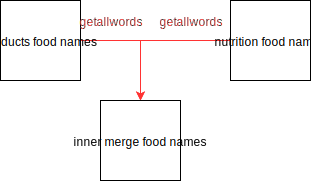

In [22]:
SVG(filename='graphs/allwords.svg')

In [23]:
#all words present in the nutrition dataset
all_words_nutrition = get_allwords(food_name_df.description)

#all words present in the product dataset
all_words_supermarket = get_allwords(products_df.ingredients)

#### Inner merge between the 2 sets of words:

_we check which words occur in both dataframes: only these words will have importance in determining the type of food article we are dealing with. Of course, if no words are known from the nutrition dataset, the sample is not taken into account._


In [24]:
common_words = pd.merge(all_words_supermarket,all_words_nutrition,left_on = 'name',right_on = 'name',suffixes=('_supermarket', '_nutrition'))

In [25]:
print(common_words.size)
common_words.head(10)

3060


,name,number_supermarket,number_nutrition
0,frozen,5755,2631
1,snacks,3178,1913
2,meat,3090,2764
3,dry,2991,2533
4,premium,2423,4906
5,cheese,2373,17371
6,drinks,2202,57
7,soft,2175,1830
8,vegetables,2056,1283
9,bag,2040,478


## Assemble them together (and pray your god)

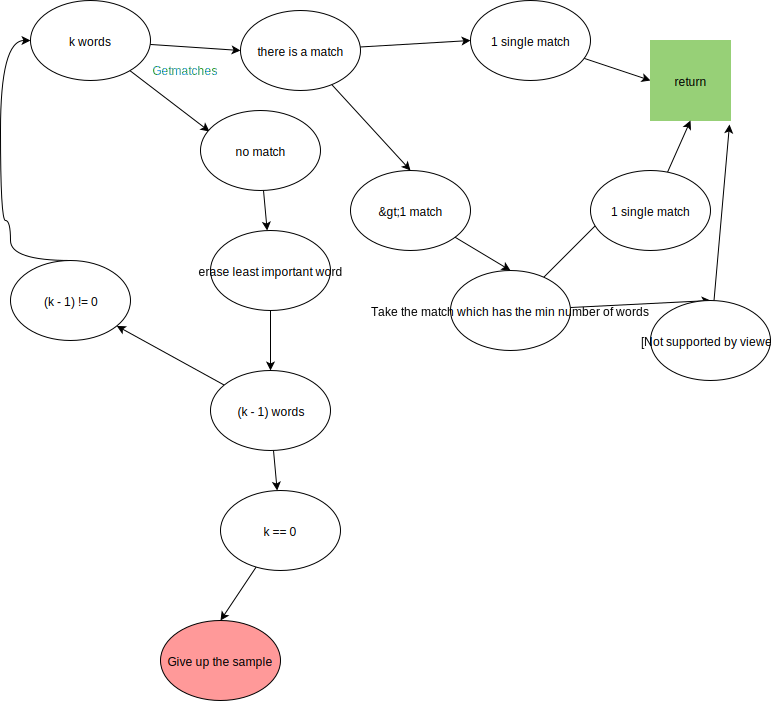

In [26]:
SVG(filename='graphs/Word_importance.svg')

In [27]:
test0 = ['duck','creamy','swiss','miss','pudding','24','oz']
test1 = ["penguin","afdadf"]
test2 = ["peanuts","orange","crisp"]
test3 = ["sandwich","lettuce","cheese"]
test4 = ["indian","lamb","josh"]
test5 = ['vanilla','creamy','swiss','miss','pudding','24','oz']
test6 = ['libbys']
test7 = ["hispanic", "oriental", "noodles"," rice"]
test8 = ["vegetables", "others"]
test9 = ["frozen", "ice", "cream", "bars"]
test10 =["wolf", "chili", "without", "beans"]

In [28]:
DIC_SCORE = construct_dic_score(common_words)

## Application of the function

In [29]:
products_df_short = products_df.head(5)

In [30]:
products_df_short

,PRODUCT_ID,CURR_SIZE_OF_PRODUCT,ingredients
0,25671,22 LB,"[frozen, ice, crushed, cubed]"
2,26093,,"[bread, italian, french]"
3,26190,50 OZ,"[fruit, shelf, stable, apple, sauce]"
4,26355,14 OZ,"[cookies, cones, specialty]"
5,26426,2.5 OZ,"[spices, extracts, seasonings]"


In [31]:
#First test on sample
estimated_df = products_df_short.copy()
findfoodshort = lambda list_words: find_food(list_words,food_name_df,DIC_SCORE,verb = True)
estimated_df["ref_fdc_id"] = products_df_short.ingredients.apply(findfoodshort).fdc_id
estimated_df.head()

./utilities/health_functions.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minsiz_matches_df["scores"] = [np.sum([dic_score.get(j,0) for j in trial]) for trial in minsiz_matches_df["match"]]


,PRODUCT_ID,CURR_SIZE_OF_PRODUCT,ingredients,ref_fdc_id
0,25671,22 LB,"[frozen, ice, crushed, cubed]",410273
2,26093,,"[bread, italian, french]",505227
3,26190,50 OZ,"[fruit, shelf, stable, apple, sauce]",168816
4,26355,14 OZ,"[cookies, cones, specialty]",528870
5,26426,2.5 OZ,"[spices, extracts, seasonings]",451829


In [32]:
#full df
estimated_total_df = products_df.copy()
findfoodtotal = lambda list_words: find_food(list_words,food_name_df,DIC_SCORE,verb = True)
#estimated_df["ref_fdc_id"] = products_df.ingredients.apply(findfoodtotal).fdc_id
estimated_df.head()
#Problem: takes more than 45 min

,PRODUCT_ID,CURR_SIZE_OF_PRODUCT,ingredients,ref_fdc_id
0,25671,22 LB,"[frozen, ice, crushed, cubed]",410273
2,26093,,"[bread, italian, french]",505227
3,26190,50 OZ,"[fruit, shelf, stable, apple, sauce]",168816
4,26355,14 OZ,"[cookies, cones, specialty]",528870
5,26426,2.5 OZ,"[spices, extracts, seasonings]",451829


In [33]:
#saves results of this lengthy computation
estimated_df.to_pickle("../data/results/products_with_link_to_nutrients_df.pickle")

We now have established the link between the dunnhumby supermarket dataset and the food database from the Department of Food and Agriculture which provides the nutrients information. We can now begin our analysis

# Analysis

In [34]:
def calculate_nutrient_per_day_per_person(key1,nutrient):
    """
    key = household key
    nutrient = nutrient for which we want to calculate the amount bought
    returns the amount of a specified nutrient bought and presumably consumed per day and per person on avergade
    in the selected household
    """
    household_transactions_df = transaction_data_df[transaction_data_df.household_key == key1]
    household_transactions_df[nutrient] = household_transactions_df["PRODUCT_ID"].apply(get_nutrient_amount,args=(nutrient,))
    time_interval = household_transactions_df["DAY"].max() - household_transactions_df["DAY"].min() + 1
    nutrient_per_household = household_transactions_df[nutrient].sum() / time_interval
    household_demographics = hh_demographic_df[hh_demographic_df.household_key == key1]
    nutrient_per_person = nutrient_per_household / household_demographics["HOUSEHOLD_SIZE_DESC"]
    return nutrient_per_person

def parse_sex_homeowner(key):
    str1 = hh_demographic_df[hh_demographic_df.household_key == key]["HH_COMP_DESC"].values[0]
    str1 = str1.lower()
    if str1.contains("female"):
            return "f"
    elif str1.contains("male"):
            return "m"
    else:
            return "unknown"
    
#TO DO
#caloric needs adult = 2000 kcal , kid = 1000 kcal -> take it into account

In [36]:
get_nutrient_amount(25671,"energy",estimated_df,food_nutrients_df)

./utilities/health_functions.py:206: PerformanceWarning: indexing past lexsort depth may impact performance.
  return food_nutrients_df1.loc[index,nutrient]["amount"].values[0]


193.0

In [37]:
transaction_data_df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [38]:
hh_demographic_df.sample(4)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
485,65+,U,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1491
726,55-64,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,2269
682,55-64,A,100-124K,Unknown,2 Adults No Kids,2,None/Unknown,2133
574,55-64,U,35-49K,Unknown,2 Adults No Kids,2,None/Unknown,1822


In [ ]:
#doesn't work because the information fdc_id is missing because the computation take too long
calculate_nutrient_per_day_per_person(255,"energy")